In [1]:
import pandas as pd                         # 데이터 분석 패키지
import numpy as np                          # 계산 패키지
import matplotlib.pyplot as plt             # 데이터 시각화 패키지
import seaborn as sns                       # 데이터 시각화 패키지

import xgboost as xgb                       # XGBoost 패키지
from sklearn.model_selection import KFold   # K-Fold CV

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
import pandas as pd

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')
submission = pd.read_csv('./data/sample_submission.csv')

In [3]:
train.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,...,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst,hhb,hbo2,ca,na
0,0,25,0.37950,0.42993,0.52076,0.57166,0.67818,0.75476,0.83580,0.93623,...,NaN,0.000000e+00,NaN,1.067504e-18,5.998949e-18,4.378513e-17,5.59,4.32,8.92,4.29
1,1,10,0.00000,0.00000,0.01813,0.00000,0.00000,0.01974,0.00321,0.00000,...,1.343132e-08,6.112685e-09,2.130547e-09,NaN,9.710091e-09,NaN,0.00,2.83,7.25,4.64
2,2,25,0.00000,0.03289,0.02416,0.03610,0.05843,0.09015,0.14944,0.18578,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.329725e-18,NaN,10.64,3.00,8.40,5.16
3,3,10,0.27503,0.31281,0.32898,0.41041,0.46587,0.52769,0.64369,0.73562,...,2.245998e-10,1.299511e-10,7.782625e-11,NaN,4.088921e-10,NaN,5.67,4.01,5.05,4.35
4,4,15,1.01521,1.00872,0.98930,0.98874,1.01773,1.01632,1.00009,0.98217,...,1.457955e-13,8.769053e-14,NaN,1.330237e-13,NaN,NaN,11.97,4.41,10.78,2.42


In [4]:
test.head()

,id,rho,650_src,660_src,670_src,680_src,690_src,700_src,710_src,720_src,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
0,10000,15,0.15406,0.23275,0.30977,0.42949,0.51264,0.62558,0.74340,0.85418,...,0.000000e+00,0.000000e+00,1.432248e-14,0.000000e+00,0.000000e+00,6.332117e-15,1.429966e-14,0.000000e+00,NaN,7.320236e-14
1,10001,15,0.48552,0.56939,0.67575,0.79089,0.85114,0.92581,0.98071,0.98177,...,1.036013e-13,NaN,2.830975e-14,1.114337e-13,4.825731e-14,NaN,2.282485e-14,7.348414e-14,1.259055e-13,2.349874e-13
2,10002,10,0.46883,0.56085,0.62442,0.73172,0.81724,0.91517,0.94801,0.99108,...,NaN,NaN,NaN,NaN,1.569208e-11,6.242378e-12,NaN,1.219010e-11,NaN,NaN
3,10003,10,0.06905,0.07517,0.10226,0.14905,0.16182,0.19659,0.26085,0.36753,...,1.651177e-11,7.282747e-12,5.010879e-12,NaN,1.571023e-11,0.000000e+00,0.000000e+00,3.304247e-12,4.106134e-11,NaN
4,10004,25,0.00253,0.00757,0.01649,0.00128,0.00000,0.00000,0.00105,0.01975,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.732057e-17,4.110605e-17,0.000000e+00,0.000000e+00,1.910775e-16,2.215673e-15


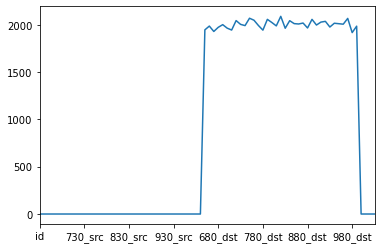

In [5]:
# train 데이터 결측치 확인

train.isna().sum().plot()

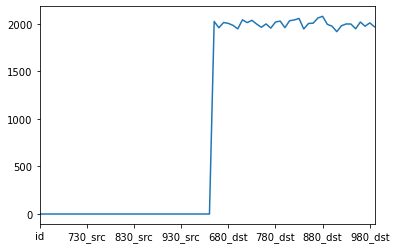

In [6]:
# test 데이터 결측치 확인

test.isna().sum().plot()

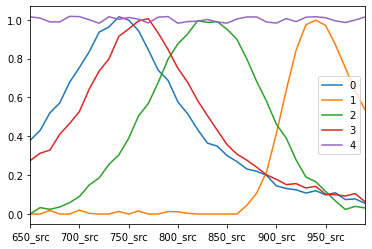

In [7]:
# train 데이터의 광원 스펙트럼 시각화

train.filter(regex='_src$',axis=1).head().T.plot()

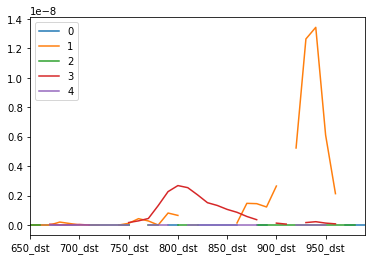

In [8]:
# train 데이터의 측정 스펙트럼 시각화

train.filter(regex='_dst$',axis=1).head().T.plot()
# 끊김현상 발견. 정확한 기계학습을 위해서 끊어진 값들 연결해야 함

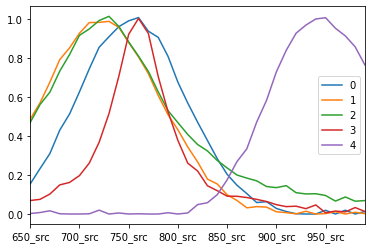

In [9]:
# test 데이터의 광원 스펙트럼 시각화

test.filter(regex='_src$',axis=1).head().T.plot()

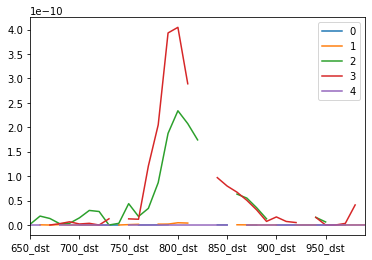

In [10]:
# test 데이터의 측정 스펙트럼 시각화

test.filter(regex='_dst$',axis=1).head().T.plot()

In [11]:
# 결측치 보간하기1 (0을 결측치로 replace)

import numpy as np

train_dst = train.filter(regex='_dst$', axis=1).replace(0, np.NaN)  # dst 데이터만 따로 뺀다.
test_dst = test.filter(regex='_dst$', axis=1).replace(0, np.NaN)    # 보간을 하기위해 결측값을 삭제한다.

train_dst.head(5)

,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
0,2.447758e-18,1.894578e-18,NaN,6.412913e-18,1.098559e-17,8.907142e-19,NaN,NaN,NaN,NaN,...,NaN,3.527371e-18,NaN,6.455564e-19,NaN,NaN,NaN,1.067504e-18,5.998949e-18,4.378513e-17
1,NaN,NaN,NaN,1.995530e-10,1.025259e-10,NaN,NaN,NaN,NaN,NaN,...,2.647633e-09,NaN,5.233480e-09,1.264238e-08,1.343132e-08,6.112685e-09,2.130547e-09,NaN,9.710091e-09,NaN
2,1.677445e-19,3.763590e-20,NaN,NaN,NaN,NaN,8.981651e-19,1.944683e-19,8.126907e-19,2.183200e-19,...,4.629125e-18,1.409413e-18,3.237480e-18,NaN,NaN,NaN,NaN,NaN,1.329725e-18,NaN
3,4.044975e-11,NaN,5.345363e-11,9.106886e-12,1.881458e-11,3.617201e-11,7.909656e-13,NaN,1.583839e-10,NaN,...,1.274876e-10,6.118947e-11,NaN,1.663888e-10,2.245998e-10,1.299511e-10,7.782625e-11,NaN,4.088921e-10,NaN
4,4.784751e-14,NaN,NaN,1.153089e-13,NaN,NaN,1.056991e-13,NaN,NaN,2.666663e-14,...,NaN,NaN,1.537619e-14,4.996522e-14,1.457955e-13,8.769053e-14,NaN,1.330237e-13,NaN,NaN


In [12]:
# 결측치 보간하기2 (선형방법으로 결측치를 채움)

train_dst = train_dst.interpolate(methods='linear', axis=1)
test_dst = test_dst.interpolate(methods='linear', axis=1)
# 스펙트럼 데이터에서 보간이 되지 않은 값은 0으로 일괄 처리한다.
train_dst.fillna(0, inplace=True) #바로적용
test_dst.fillna(0, inplace=True)

train_dst.head(5)

,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
0,2.447758e-18,1.894578e-18,4.153745e-18,6.412913e-18,1.098559e-17,8.907142e-19,1.892920e-18,2.895126e-18,3.897332e-18,4.899539e-18,...,3.076794e-18,3.527371e-18,2.086464e-18,6.455564e-19,7.510433e-19,8.565303e-19,9.620173e-19,1.067504e-18,5.998949e-18,4.378513e-17
1,0.000000e+00,0.000000e+00,0.000000e+00,1.995530e-10,1.025259e-10,1.046220e-10,1.067180e-10,1.088140e-10,1.109100e-10,1.130060e-10,...,2.647633e-09,3.940557e-09,5.233480e-09,1.264238e-08,1.343132e-08,6.112685e-09,2.130547e-09,5.920319e-09,9.710091e-09,9.710091e-09
2,1.677445e-19,3.763590e-20,2.097417e-19,3.818476e-19,5.539534e-19,7.260593e-19,8.981651e-19,1.944683e-19,8.126907e-19,2.183200e-19,...,4.629125e-18,1.409413e-18,3.237480e-18,2.919521e-18,2.601562e-18,2.283602e-18,1.965643e-18,1.647684e-18,1.329725e-18,1.329725e-18
3,4.044975e-11,4.695169e-11,5.345363e-11,9.106886e-12,1.881458e-11,3.617201e-11,7.909656e-13,7.958742e-11,1.583839e-10,1.630944e-10,...,1.274876e-10,6.118947e-11,1.137891e-10,1.663888e-10,2.245998e-10,1.299511e-10,7.782625e-11,2.433592e-10,4.088921e-10,4.088921e-10
4,4.784751e-14,7.033465e-14,9.282179e-14,1.153089e-13,1.121056e-13,1.089024e-13,1.056991e-13,7.935493e-14,5.301078e-14,2.666663e-14,...,8.737755e-14,5.137687e-14,1.537619e-14,4.996522e-14,1.457955e-13,8.769053e-14,1.103571e-13,1.330237e-13,1.330237e-13,1.330237e-13


In [13]:
test_dst.head(5)

,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
0,0.000000e+00,0.000000e+00,7.028318e-15,1.199001e-14,1.695171e-14,2.191340e-14,2.204989e-14,1.513555e-14,8.221207e-15,1.306867e-15,...,1.808883e-14,1.620565e-14,1.432248e-14,1.165902e-14,8.995570e-15,6.332117e-15,1.429966e-14,3.393389e-14,5.356813e-14,7.320236e-14
1,0.000000e+00,3.744801e-13,1.190392e-14,9.131521e-13,1.796724e-14,1.081485e-14,1.263854e-14,1.446222e-14,1.628590e-14,1.810959e-14,...,1.036013e-13,6.595554e-14,2.830975e-14,1.114337e-13,4.825731e-14,3.554108e-14,2.282485e-14,7.348414e-14,1.259055e-13,2.349874e-13
2,1.732202e-12,1.827363e-11,1.332869e-11,2.641682e-12,3.498661e-12,1.466659e-11,2.981251e-11,2.764069e-11,1.553192e-11,3.423157e-12,...,1.325728e-11,1.386598e-11,1.447468e-11,1.508338e-11,1.569208e-11,6.242378e-12,9.216241e-12,1.219010e-11,1.219010e-11,1.219010e-11
3,0.000000e+00,0.000000e+00,0.000000e+00,2.713471e-12,6.567726e-12,2.069053e-12,3.467277e-12,8.110039e-12,1.275280e-11,1.266541e-11,...,1.651177e-11,7.282747e-12,5.010879e-12,1.036055e-11,1.571023e-11,1.157490e-11,7.439573e-12,3.304247e-12,4.106134e-11,4.106134e-11
4,0.000000e+00,4.030214e-17,3.265115e-17,2.500016e-17,2.867409e-17,3.234803e-17,3.602197e-17,3.969590e-17,1.461565e-18,5.603958e-18,...,4.048939e-17,3.969718e-17,3.890498e-17,3.811277e-17,3.732057e-17,4.110605e-17,9.109653e-17,1.410870e-16,1.910775e-16,2.215673e-15


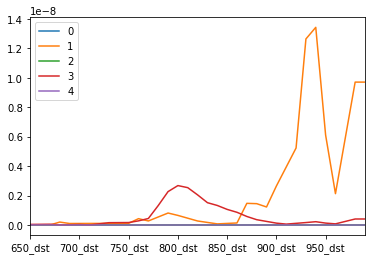

In [14]:
train_dst.head().T.plot()

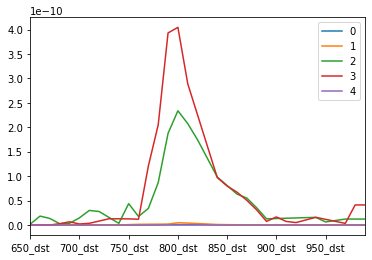

In [15]:
test_dst.head().T.plot()

In [17]:
train.update(train_dst) # 보간한 데이터를 기존 데이터프레임에 업데이트 한다.
test.update(test_dst)

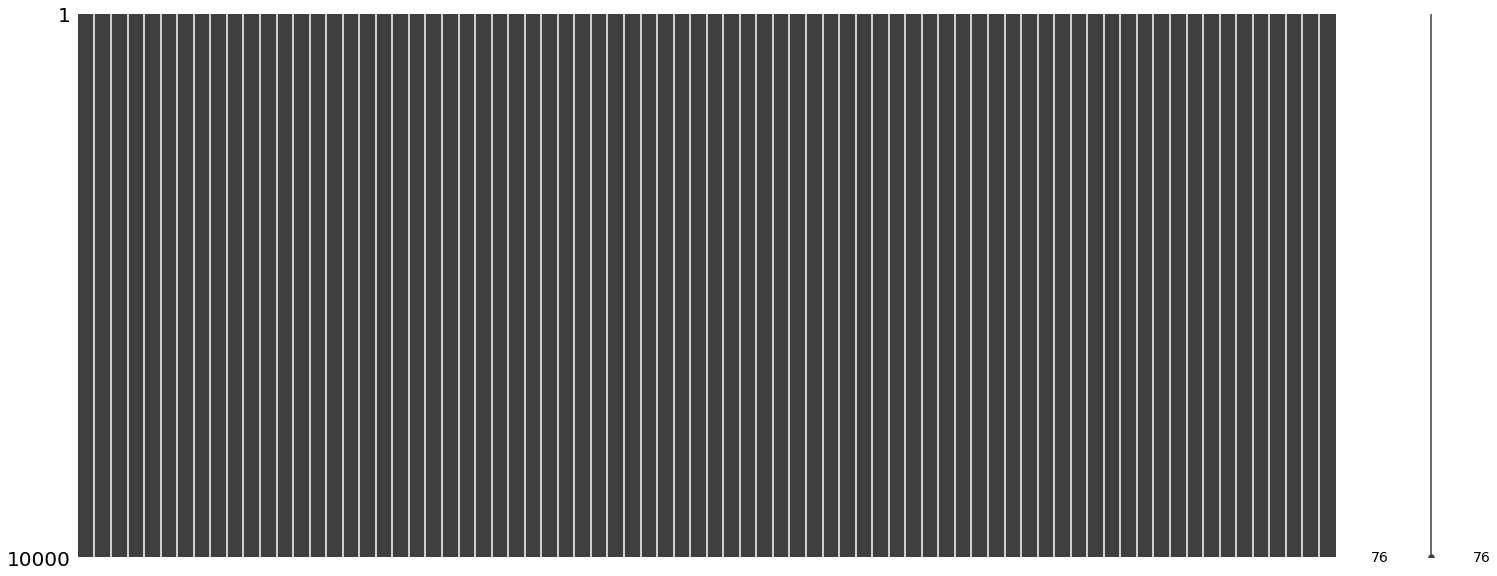

In [18]:
import missingno as msno

msno.matrix(train)

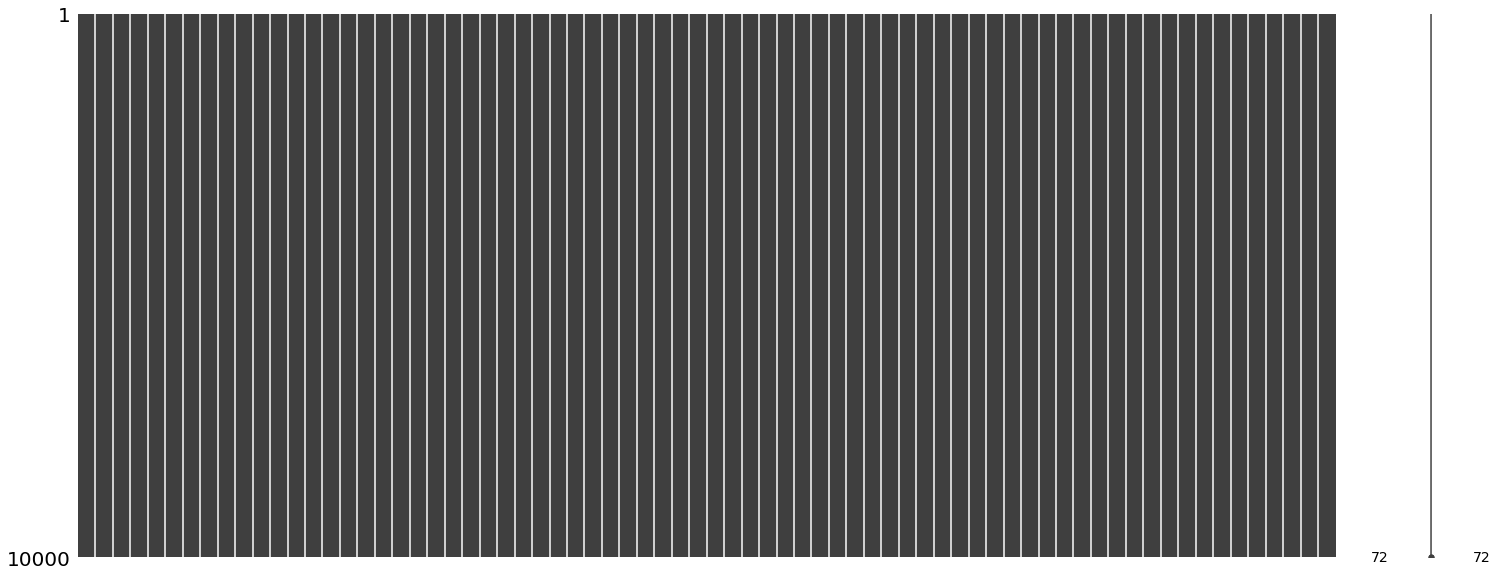

In [19]:
msno.matrix(test)

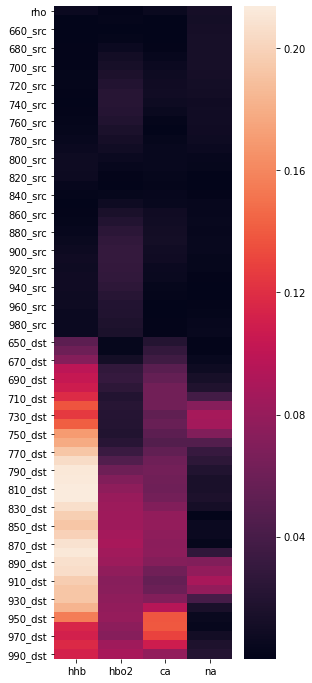

In [20]:
# 데이터 시각화
# 데이터와 hho, hbo2, ca, na의 상관관계 분석
# 비교적 상관관계가 큰 dst컬럼을 feature로 선정

plt.figure(figsize=(4, 12))
sns.heatmap(train.corr().loc['rho':'990_dst', 'hhb':].abs())

In [21]:
x_train = train.loc[:, '650_dst':'990_dst']
y_train = train.loc[:, 'hhb':'na']
x_train.shape, y_train.shape

((10000, 35), (10000, 4))

In [22]:
x_train.head()

,650_dst,660_dst,670_dst,680_dst,690_dst,700_dst,710_dst,720_dst,730_dst,740_dst,...,900_dst,910_dst,920_dst,930_dst,940_dst,950_dst,960_dst,970_dst,980_dst,990_dst
0,2.447758e-18,1.894578e-18,4.153745e-18,6.412913e-18,1.098559e-17,8.907142e-19,1.892920e-18,2.895126e-18,3.897332e-18,4.899539e-18,...,3.076794e-18,3.527371e-18,2.086464e-18,6.455564e-19,7.510433e-19,8.565303e-19,9.620173e-19,1.067504e-18,5.998949e-18,4.378513e-17
1,0.000000e+00,0.000000e+00,0.000000e+00,1.995530e-10,1.025259e-10,1.046220e-10,1.067180e-10,1.088140e-10,1.109100e-10,1.130060e-10,...,2.647633e-09,3.940557e-09,5.233480e-09,1.264238e-08,1.343132e-08,6.112685e-09,2.130547e-09,5.920319e-09,9.710091e-09,9.710091e-09
2,1.677445e-19,3.763590e-20,2.097417e-19,3.818476e-19,5.539534e-19,7.260593e-19,8.981651e-19,1.944683e-19,8.126907e-19,2.183200e-19,...,4.629125e-18,1.409413e-18,3.237480e-18,2.919521e-18,2.601562e-18,2.283602e-18,1.965643e-18,1.647684e-18,1.329725e-18,1.329725e-18
3,4.044975e-11,4.695169e-11,5.345363e-11,9.106886e-12,1.881458e-11,3.617201e-11,7.909656e-13,7.958742e-11,1.583839e-10,1.630944e-10,...,1.274876e-10,6.118947e-11,1.137891e-10,1.663888e-10,2.245998e-10,1.299511e-10,7.782625e-11,2.433592e-10,4.088921e-10,4.088921e-10
4,4.784751e-14,7.033465e-14,9.282179e-14,1.153089e-13,1.121056e-13,1.089024e-13,1.056991e-13,7.935493e-14,5.301078e-14,2.666663e-14,...,8.737755e-14,5.137687e-14,1.537619e-14,4.996522e-14,1.457955e-13,8.769053e-14,1.103571e-13,1.330237e-13,1.330237e-13,1.330237e-13


In [23]:
y_train.head()

,hhb,hbo2,ca,na
0,5.59,4.32,8.92,4.29
1,0.00,2.83,7.25,4.64
2,10.64,3.00,8.40,5.16
3,5.67,4.01,5.05,4.35
4,11.97,4.41,10.78,2.42


In [24]:
def train_model(x_data, y_data, k=5):
    models = []
    
    k_fold = KFold(n_splits=k, shuffle=True, random_state=123)
    
    for train_idx, val_idx in k_fold.split(x_data):
        x_train, y_train = x_data.iloc[train_idx], y_data[train_idx]
        x_val, y_val = x_data.iloc[val_idx], y_data[val_idx]
    
        d_train = xgb.DMatrix(data = x_train, label = y_train)
        d_val = xgb.DMatrix(data = x_val, label = y_val)
        
        wlist = [(d_train, 'train'), (d_val, 'eval')]
        
        params = {
            'objective': 'reg:squarederror',
            'eval_metric': 'mae',
            'seed':777
            }

        model = xgb.train(params=params, dtrain=d_train, num_boost_round=500, verbose_eval=500, evals=wlist)
        models.append(model)
    
    return models

In [25]:
models = {}
for label in y_train.columns:
    print('train column : ', label)
    models[label] = train_model(x_train, y_train[label])

train column :  hhb
[0]	train-mae:5.32433	eval-mae:5.30763
[499]	train-mae:0.05625	eval-mae:1.69190
[0]	train-mae:5.32628	eval-mae:5.27542
[499]	train-mae:0.05068	eval-mae:1.68700
[0]	train-mae:5.31965	eval-mae:5.31869
[499]	train-mae:0.05327	eval-mae:1.75407
[0]	train-mae:5.31646	eval-mae:5.35798
[499]	train-mae:0.05440	eval-mae:1.71719
[0]	train-mae:5.31060	eval-mae:5.37270
[499]	train-mae:0.05517	eval-mae:1.67181
train column :  hbo2
[0]	train-mae:2.46038	eval-mae:2.47214
[499]	train-mae:0.02748	eval-mae:0.76861
[0]	train-mae:2.45966	eval-mae:2.48090
[499]	train-mae:0.02852	eval-mae:0.77789
[0]	train-mae:2.46844	eval-mae:2.42823
[499]	train-mae:0.02783	eval-mae:0.77586
[0]	train-mae:2.45916	eval-mae:2.47745
[499]	train-mae:0.02883	eval-mae:0.77443
[0]	train-mae:2.46326	eval-mae:2.45661
[499]	train-mae:0.02785	eval-mae:0.77936
train column :  ca
[0]	train-mae:5.99643	eval-mae:6.07908
[499]	train-mae:0.07275	eval-mae:2.29993
[0]	train-mae:6.00434	eval-mae:6.02053
[499]	train-mae:0.071

In [26]:
for col in models:
    preds = []
    for model in models[col]:
        preds.append(model.predict(xgb.DMatrix(test.loc[:, '650_dst':])))
    pred = np.mean(preds, axis=0)

    submission[col] = pred

In [27]:
submission.head()

,id,hhb,hbo2,ca,na
0,10000,8.464289,4.615035,8.720705,2.267622
1,10001,6.714589,3.139178,10.327036,4.433312
2,10002,8.058420,4.151024,11.017254,3.485149
3,10003,8.488432,4.251945,9.208483,4.038161
4,10004,6.882690,3.010647,9.584661,2.841910


In [28]:
submission.to_csv('Dacon_200613_2.csv', index=False)